# **Занятие 6. Свёрточные нейронные сети. Классификация цветных изображений**

https://vk.com/lambda_brain

Рассмотрим случай, когда входные данные -- это цветные изображения. Для обработки таких данных были придуманы **свёрточные нейронные сети**, воспользуемся для этого одной из классических моделей.

---

Импортируем нужные пакеты:

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

Будем обрабатывать стандартный датасет **CIFAR10**, который включает фотографии десяти классов: самолёт, автомобиль, птица, кот, олень, собака, лягушка, лошадь, корабль и грузовик. На каждый класс приходится по 6000 (5000 обучающих и 1000 тестовых) цветных изображений размером 32 * 32 пиксела (и три канала цветности RGB).

In [0]:
input_size = 3*32*32   # Размер изображения в точках * количество цветов
num_classes = 10       # Количество распознающихся классов (10 видов изображений)
n_epochs = 12           # Количество эпох
batch_size = 150         # Размер мини-пакета входных данных
lr = 0.001             # Скорость обучения

Из-за специфики представления цветных изображений мы не можем сразу брать их в сыром виде: сперва требуется нормализовать картинки, превратить их в изображения в серой палитре с интенсивностью цвета в диапазоне 0..1. Это делает стандартная функция **Normalize()** из torchvision.transforms, которой в качестве параметров в подобных случаях обычно указываются стандартные значения (среднее и стандартное отклонение) для такой нормализации (0.5, 0.5, 0.5).

То есть нам нужно выполнить композицию трансформаций: сперва выполнить преобразование в тензоры, и затем нормализовать. 

Композицию выполняет стандартная функция torchvision.transforms **.Compose()**. Её результат мы и задаём в качестве параметра transform конструктора CIFAR10.

In [262]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = dsets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


Аналогично подготовим и тестовый датасет:

In [263]:
cifar_testset = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print(len(cifar_trainset))
print(len(cifar_testset))

Files already downloaded and verified
50000
10000


Загрузим наши данные:

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=cifar_trainset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=cifar_testset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Добавим стандартный шаг обучения:

In [0]:
# импортируем нужные библиотеки
import torch
import numpy as np # всегда пригодится :)
from torch.nn import Linear, Sigmoid

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# добавляем типовую функцию "шаг обучения"
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

Какую задействовать модель? Вообще, конструирование наиболее эффективных моделей -- это искусство плюс математика. На практике часто можно пользоваться либо простыми стандартными решениями (как было например в случае распознавания рукописных цифр), либо сложными моделями, которые под соответствующие классы задач придумали ведущие специалисты в ML. 
В нашем случае мы применим модель LeNet, предложенную Яном ЛеКуном -- она относится к так называемым **свёрточным нейронным сетям (Convolutional Neural Network, CNN)**, хорошо работающим с двумерными изображениями.


---

Подробное описание принципов работы CNN:

https://neurohive.io/ru/tutorial/cnn-na-pytorch/

Главное, обратите внимание на принцип **свёртки** и движущееся окно/**фильтр**.
 
**Пулинг (pooling)** -- это схожая со скользящим окном техника, когда вместо свёртки по обучаемым весам к значениям в окне применяется некоторая статистическая функция (среднее, максимум, ...). Так, популярная механика тут -- это max pooling. Пулинг выполняет обобщение мелких деталей, устойчиво выделяет некоторый признак независимо от его размера и ориентации.

**Канал** -- это множество фильтров, формирующих оригинальный двумерный вывод. Каналы нередко связываются с цветностью изображения.


In [0]:
import torch.nn as nn
import torch.nn.functional as F


class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 5, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(50,120, 3, padding=1)
        #self.conv3 = nn.Conv2d(64,128, 4)
        self.fc1 = nn.Linear(120 * 8 * 8, 1200)
        self.fc2 = nn.Linear(1200, 80)
        
        self.fc3 = nn.Linear(80, 10)
        #self.dropOut = nn.Dropout()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 120 * 8 * 8)
        #x = self.dropOut(x)
        x = F.sigmoid(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        return x



Рассмотрим структуру этой модели подробнее.

По мелким техническим причинам (необходимость выравнивания данных при переходе от свёрточных слоёв к линейным) её удобнее представить в формате классической модели, а не просто композицией слоёв.

Первый слой -- Conv2d(3, 6, 5) с функцией активации ReLU создаёт набор свёрточных фильтров. Первый параметр 3 -- это количество входных каналов изображений, три цвета. Второй параметр 6 -- это количество выходных каналов, третий параметр -- размер фильтра 5x5. На выходе получается 6 фильтров размером 3x5x5 -- и всего модель выделяет (3 * 5 * 5 + 1) * 6 = 456 параметров.
Выходной размер слоя получится 6 * 28 * 28 , где 28 = ((32 - 5) + 1)

Метод MaxPool2d(2,2) -- это реализация max-пулинга (вычисление его аргументов см. по ссылке выше). kernel_size -- размер окна пулинга, stride -- шаг пулинга. Выходной размер слоя таким образом снижаем в два раза: с 6 * 28 * 28 до 6 * 14 * 14.


Далее снова применяется функция Conv2d(6, 16, 5) -- шесть выходных каналов предыдущей функций как входы. Теперь мы применяем 16 фильтров (каждый размером 6 * 5 * 5), и выходной размер слоя будет 16 * 10 * 10, где 10 = (14 - 5) + 1. Всего на уровне обрабатывается (5 * 5 * 6 + 1) * 16 = 2416 параметров.

Следующий max pooling снижает этот выход в два раза -- с 16 * 10 * 10 до 16 * 5 * 5.

И в заключение добавляются три полносвязных слоя Linear. Обратите внимание, что перед ними надо выполнить модификацию структуры передаваемых данных, так как свёрточные слои работают с двумерными изображениями, а линейные -- с векторными наборами. Такое преобразование выполняет x.view(-1, 16 * 5 * 5).

Первый линейный слой из 120 узлов, получает 16 * 5 * 5 входов -- то есть в нём требуется (16 * 5 * 5 + 1) * 120 = 48120 параметров, и далее количество входов-выходов понижается через следующие слои до наших итоговых 10 классов (последний уровень требует (84+1) * 10 = 850 параметров).


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.31444409489631653


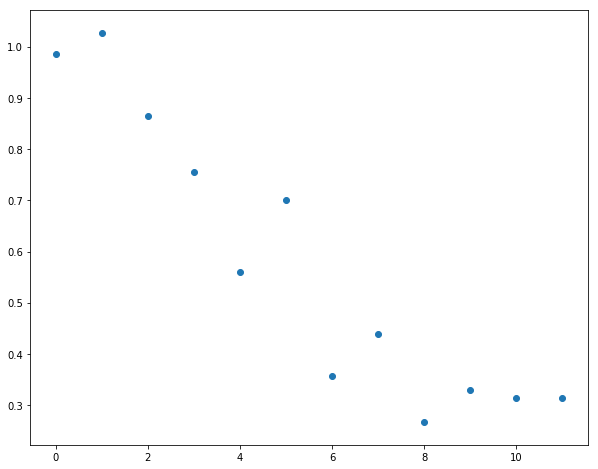

In [267]:
from torch import optim, nn

model = CifarModel()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
  
train_step = make_train_step(model, loss_fn, optimizer)

loss_list = []

for epoch in range(n_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        loss = train_step(images, labels)
    loss_list.append(loss)
        
# print(model.state_dict())    
print(loss)

plt.figure(figsize=(10, 8))
plt.scatter(range(n_epochs),loss_list,  cmap='rainbow')
plt.show()

In [268]:
with torch.no_grad(): # проверяем на тестовой выборке
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Точность: 72.74 %


Считаем точность -- она получается в районе 55%. Это хороший результат, так как при случайном выборе мы получили бы 10%. Причём её можно существенно повысить -- уже после 10 эпох обучения мы получим точность 80+%!


---

Визуализируем результаты кодом из предыдущего занятия:

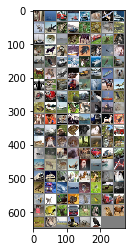

        кот     корабль  автомобиль     корабль     лягушка         кот     самолёт     корабль       олень     самолёт     лягушка  автомобиль       олень       птица         кот      лошадь  автомобиль     лягушка     корабль     лягушка      лошадь  автомобиль     лягушка         кот       олень      лошадь       птица     корабль     лягушка      собака     самолёт      собака     корабль       птица    грузовик     самолёт         кот     корабль       птица    грузовик      лошадь      собака     самолёт     лягушка    грузовик     корабль     корабль      собака     самолёт      собака         кот    грузовик       птица     самолёт      лошадь     самолёт    грузовик  автомобиль     корабль       птица    грузовик         кот     корабль       птица     лягушка     самолёт     самолёт     лягушка         кот         кот     самолёт      собака      собака      собака      лошадь    грузовик     корабль    грузовик      собака       птица     корабль     самолёт      собака     

In [269]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('самолёт', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%11s' % classes[labels[j]] for j in range(batch_size)))

В заключение вычислим точность распознавания по каждому из признаков:

In [270]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Точность для %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Точность для самолёт : 90 %
Точность для автомобиль : 90 %
Точность для птица : 62 %
Точность для   кот : 65 %
Точность для олень : 58 %
Точность для собака : 70 %
Точность для лягушка : 73 %
Точность для лошадь : 69 %
Точность для корабль : 81 %
Точность для грузовик : 82 %


## **Задание.** 
Увеличение количества эпох (шагов обучения) существенно повышает качество модели. Но есть и другие способы -- поэкспериментируйте например с добавлением новых свёрточных или линейных слоёв, размерами фильтров и их количеством. В процессе экспериментов избегайте переобучения -- когда модель показывает отличные результаты на обучающей выборке, но невысокие на тестовой.


---

В следующем занятии мы займёмся экспериментами с уже обученными моделями.